# Trading at the Close - Feature Engineering
-----------------------
-----------------------

Feature selection involves picking the set of features that are most relevant to the target variable. This helps in reducing the complexity of the model, as well as minimizing the resources required for training and inference. This has greater effect in production models where one maybe dealing with terabytes of data or serving millions of requests.

Most of the modules will come from [scikit-learn](https://scikit-learn.org/stable/), one of the most commonly used machine learning libraries. It features various machine learning algorithms and has built-in implementations of different feature selection methods. Using these, you will be able to compare which method works best for this particular dataset.

## Installs
-----------

In [1]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


## Imports
------------------



In [2]:
# for data processing and manipulation
import pandas as pd
import numpy as np
from pathlib import Path

# scikit-learn modules for feature selection and model evaluation
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error 
from lightgbm import LGBMRegressor
import lightgbm as lgb
from loguru import logger
from pprint import pformat, pprint

from utils.validation import TrainTestSplit

# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_style("ticks")

%load_ext autoreload
%autoreload 2

## Configuration
--------------------------

This cell defines the configuration to use throughout this notebook for feature selection.

In [3]:
class CFG:
    JOBS_PATH = Path(".", "job_artifacts")
    JOB_NAME = "optiver-feature_selection"
    INPUT_METADATA_PATH = JOBS_PATH.joinpath("optiver-cluster_and_weights-0001")
    INPUT_METADATA_NAME = "output_metadata.json"
    TRAINING_PATH = Path(".", "train_files", "train.csv")
    OUTPUT_METADATA_NAME = "output_metadata.json"
    RANDOM_STATE = 1024
    USE_GPU = False
    MODEL = LGBMRegressor
    N_FOLDS = 1
    TEST_SIZE = 45
    N_JOBS = 1
    FEAT_COUNT= -1 # .-1 deactivates feature selection

In [16]:
def lgbm_params():
    """Returns algorithm parameters."""

    params = {
        "device"            : "gpu" if CFG.USE_GPU else "cpu",
        "objective"         : "mae",
        "boosting_type"     : "gbdt",
        "max_depth"         : 9,
        "num_leaves"        : 320,
        "n_estimators"      : 6000,
        "subsample"         : 0.82,
        "min_child_samples" : 55,
        "colsample_bytree"  : 0.66,
        "reg_alpha"         : 0.005,
        "reg_lambda"        : 0.005,
        "learning_rate"     : 0.05,
        "random_state"      : CFG.RANDOM_STATE,
        "n_jobs"            : 3,
        "verbose"           : -1
    }

    return params


MODEL_CFG = {
    LGBMRegressor.__name__ : {
        "params_func": lgbm_params,
        "callbacks": [lgb.early_stopping(50), lgb.log_evaluation(100)]
    }
}

Create the artifacts folder tree incrementally. Each run will correspond to a different folder.

In [5]:
CFG.JOBS_PATH.mkdir(exist_ok=True, parents=True)

for i in range(1, 10000):
    CFG.JOB_PATH = CFG.JOBS_PATH.joinpath(CFG.JOB_NAME + "-" +  str(i).zfill(4))
    try:
        CFG.JOB_PATH.mkdir()
        break
    except:
        continue

## Define Helper Functions
-------------------------

The following cells define helper functions for feature creation and selection.

In [6]:
%%writefile utils/features.py

import numpy as np
import pandas as pd
from itertools import combinations
from pathlib import Path
from typing import List, Mapping, Any
from numba import njit, prange

try:
    from loguru import logger
except:
    import logging
    logger = logging.getLogger("__main__")

from .compression import downcast


#==============================================================================

# Log return
def log_return(series):
    return np.log(series).diff()


# 📊 Function to compute triplet imbalance in parallel using Numba
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    # 🔁 Loop through all combinations of triplets
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        
        # 🔁 Loop through rows of the DataFrame
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            # 🚫 Prevent division by zero
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

#==============================================================================

# Function to calculate triplet imbalance for given price data and a DataFrame
def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance using the Numba-optimized function
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}.{b}.{c}.imbalance" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features


#==============================================================================

@njit
def moving_avg(arr: np.ndarray, window: int, min_periods: int = 1) -> np.ndarray:
    result = np.full(arr.shape, np.nan)  # Fill with nan
    if min_periods is None:
        min_periods = window

    for i in range(arr.shape[0]):
        windowed_data = arr[max(0, i - window + 1) : i + 1]
        valid_count = np.sum(~np.isnan(windowed_data))
        if valid_count >= min_periods:
            result[i] = np.nanmean(windowed_data)  # Compute mean considering possible NaN values

    return result

#==============================================================================

def get_moving_avg(x, lookback=10):
    x = x.to_numpy()
    return moving_avg(x, lookback)

#==============================================================================

@njit
def weighted_avg(values: np.ndarray, weights: np.ndarray):
    """
    Return the weighted average.

    values, weights -- NumPy ndarrays with the same shape.
    """
    masked_values = values[~np.isnan(values)]
    masked_weights = weights[~np.isnan(values)]

    return np.average(masked_values, weights=masked_weights)


#==============================================================================

def get_weighted_avg(x: pd.Series):

    weights = x["stock_weights"].to_numpy().ravel()
    values = x.drop(columns=["stock_weights"]).to_numpy().ravel()

    return weighted_avg(values, weights)

#==============================================================================

@njit
def weighted_std(values, weights):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """

    masked_values = values[~np.isnan(values)]
    masked_weights = weights[~np.isnan(values)]

    average = np.average(masked_values, weights=masked_weights)

    # Fast and numerically precise:
    variance = np.average((masked_values - average)**2, weights=masked_weights)
    return np.sqrt(variance)

#==============================================================================

def get_weighted_std(x: pd.Series):

    weights = x["stock_weights"].to_numpy().ravel()
    values = x.drop(columns=["stock_weights"]).to_numpy().ravel()

    return weighted_std(values, weights)

#==============================================================================

# Function to do the feature engineering
def feature_engineering(
    df: pd.DataFrame, 
    weights: Mapping[int, Any] = None,
    clusters: Mapping[int, Any] = None,
    revealed_target: bool = True, 
    reduce_memory: bool = True
) -> pd.DataFrame:

    ########################
    # Time features
    ########################
    logger.info("Generating time features...")
    df = generate_time_features(df)

    ########################
    # Size-only features
    ########################
    logger.info("Generating size features...")
    df = generate_size_features(df)

    ########################
    # Price-only features
    ########################
    logger.info("Generating price features...")
    df = generate_price_features(df)

    ########################
    # Mixed features
    ########################
    logger.info("Generating mixed features...")
    df = generate_mixed_features(df)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    ########################
    # Aggregated features
    ########################
    logger.info("Generating aggregated features...")
    df = generate_aggregated_features(df, weights, clusters)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    ########################
    # Rolling features
    ########################
    logger.info("Generating rolling features...")
    df = generate_rolling_features(df, revealed_target)

    ########################
    # A bit of cleaning
    ########################
    # Replace infinite values with nulls
    #df.replace([np.inf, -np.inf], 0)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df

#==============================================================================

def generate_size_features(df: pd.DataFrame) -> pd.DataFrame:
    # Calculate size-related features
    """
    df["ask_size.bid_size.total"] = df["ask_size"] + df["bid_size"]
    df["ask_size.bid_size.spread"] = df["ask_size"] - df["bid_size"]
    df["ask_size.bid_size.imbalance"] = (df["ask_size"] - df["bid_size"]) / (df["bid_size"] + df["ask_size"])
    df["imbalance_size.matched_size.imbalance"] = (df["imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["imbalance_size"])
    df["bid_size.ask_size.ratio"] = df["bid_size"] / df["ask_size"]
    df["imbalance_size.matched_size.ratio"] = df["imbalance_size"] / df["matched_size"]
    """

    sizes = ["ask_size", "bid_size", "imbalance_size", "matched_size"]
    for c in combinations(sizes, 2):
        df[f"{c[0]}.{c[1]}.spread"] = df[c[0]] - df[c[1]]
        df[f"{c[0]}.{c[1]}.total"] = df[c[0]] + df[c[1]]
        df[f"{c[0]}.{c[1]}.ratio"] = df[c[0]] / df[c[1]]
        df[f"{c[0]}.{c[1]}.imbalance"] = (df[c[0]] - df[c[1]])/(df[c[0]] + df[c[1]])

    """
    sizes = ["imbalance_size", "matched_size"]
    for c in combinations(sizes, 2):
        df[f"{c[0]}.{c[1]}.ratio"] = df[c[0]] / df[c[1]]
        df[f"{c[0]}.{c[1]}.imbalance"] = (df[c[0]] - df[c[1]])/(df[c[0]] + df[c[1]])
    """

    # Calculate triplet imbalance features
    for c in combinations(sizes, 3):
        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1) - min_ - max_

        df[f"{c[0]}.{c[1]}.{c[2]}.imbalance"] = (max_ - mid_)/(mid_ - min_)

    return df

#==============================================================================

def generate_price_features(df: pd.DataFrame) -> pd.DataFrame:

    # Calculate price-related features
    df["ask_price.bid_price.mean"] = (df["ask_price"] + df["bid_price"]) / 2

    # Create features for pairwise price imbalances
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    for c in combinations(prices, 2):
        df[f"{c[0]}.{c[1]}.spread"] = df[c[0]] - df[c[1]]
        df[f"{c[0]}.{c[1]}.imbalance"] = (df[c[0]] - df[c[1]])/(df[c[0]] + df[c[1]])

    # Calculate triplet imbalance features using the Numba-optimized function
    for c in combinations(prices, 3):
        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1) - min_ - max_

        df[f"{c[0]}.{c[1]}.{c[2]}.imbalance"] = (max_ - mid_)/(mid_ - min_)

    """
    # Calculate triplet imbalance features using the Numba-optimized function
    prices = ["ask_price", "bid_price", "wap", "reference_price"]
    triplet_feature = calculate_triplet_imbalance_numba(prices, df)
    df[triplet_feature.columns] = triplet_feature.values
    """

    return df

#==============================================================================

def generate_time_features(df: pd.DataFrame) -> pd.DataFrame:

    #df["dow"] = df["date_id"] % 5  # Day of the week
    #df["seconds"] = df["seconds_in_bucket"] % 60  # Seconds
    #df["minute"] = df["seconds_in_bucket"] // 60  # Minutes

    return df

#==============================================================================

def generate_mixed_features(df: pd.DataFrame) -> pd.DataFrame:

    # Calculate additional features
    #df["prices.spread.imbalance_size.bid_price.product"] = df["ask_price.bid_price.spread"] * df["imbalance_size"] 
    df["prices.spread.sizes.imbalance.product"] = df["ask_price.bid_price.spread"] * df["ask_size.bid_size.imbalance"]
    #df["prices.spread.product"] = df["ask_price.bid_price.spread"] * df["far_price.near_price.spread"]
    df["imbalance_buy_sell_flag"] += 1

    #df["ask_price.ask_size.product"] = df["ask_price"] * df["ask_size"]
    #df["bid_price.bid_size.product"] = df["bid_price"] * df["bid_size"]
    #df["wap.size.product"] = df["wap"] * df["ask_size.bid_size.total"]
    #df["reference_price.size.product"] = df["reference_price"] * df["ask_size.bid_size.total"]
    #df["far_price.ask_size.product"] = df["far_price"] * df["ask_size"]
    #df["near_price.bid_size.product"] = df["near_price"] * df["bid_size"]

    """
    price_size = ["ask_price.ask_size.product", "bid_price.bid_size.product", "wap.size.product", "ask_price", "bid_price", "wap"]
    for c in combinations(price_size, 2):
        df[f"{c[0]}.{c[1]}.spread"] = df[c[0]] - df[c[1]]
        df[f"{c[0]}.{c[1]}.imbalance"] = (df[c[0]] - df[c[1]])/(df[c[0]] + df[c[1]])
    """


    return df

#==============================================================================

def generate_rolling_features(df: pd.DataFrame, revealed_target: bool = True) -> pd.DataFrame:

    """
    df["imbalance_size.diff.matched_size.ratio"] = df.groupby("stock_id")["imbalance_size"].diff(periods=1) / df["matched_size"]
    df["ask_price.bid_price.spread.diff"] = df.groupby("stock_id")["ask_price.bid_price.spread"].diff()

    # Calculate shifted and return features for specific columns
    for col in ["matched_size", "imbalance_size", "reference_price", "imbalance_buy_sell_flag"]:
        for window in [1, 2, 3, 10]:
            df[f"{col}.shift.{window}"] = df.groupby("stock_id")[col].shift(window)
            df[f"{col}.pct_change.{window}"] = df.groupby("stock_id")[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ["ask_price", "bid_price", "ask_size", "bid_size"]:
        for window in [1, 2, 3, 10]:
            df[f"{col}.diff.{window}"] = df.groupby("stock_id")[col].diff(window)
    """

    # Add revealed target
    if revealed_target:
        target_sample = df.groupby(["stock_id", "seconds_in_bucket"])
        df[f"revealed_target"] = target_sample["target"].shift(1)

    rolling_sample = df.groupby(["stock_id", "date_id"])
    df[f"imbalance_buy_sell_flag.shift.1"] = rolling_sample["imbalance_buy_sell_flag"].shift(1)

    columns = ["ask_size", "bid_size", "matched_size", "imbalance_size", "ask_price", "bid_price", "reference_price", 
               "wap", "far_price", "near_price"]
    for col in columns:
        for window in [1,]:
            df[f"{col}.pct_change.{window}"] = rolling_sample[col].pct_change(window)

    #df[f"wap.pct_change.1"] = rolling_sample["wap"].pct_change(1)

    return df

#==============================================================================

def apply_aggregations(
    aggr_index: List[str],
    aggr_mappings: Mapping[str, Any],
    df: pd.DataFrame,
    suffix: str = "aggr"
) -> pd.DataFrame:

    aggr_df = None
    # Perform aggregations and features dependent on these
    for key, value in aggr_mappings.items():
        aggr_colum = pd.Series(value, name=key + "." + suffix)
        aggr_colum.index = aggr_colum.index.set_names(aggr_index)
    
        if aggr_df is None:
            aggr_df = pd.DataFrame(aggr_colum)
        else:
            aggr_df[key + "." + suffix] = aggr_colum

    df = pd.merge(df, aggr_df, on=aggr_index, how="left")

    return df

#==============================================================================


def generate_aggregated_features(df: pd.DataFrame, weights: Mapping[int, Any] = None, clusters: Mapping[int, Any] = None) -> None:

    apply_engine = "numba"

    sizes = ["ask_size", "bid_size", "imbalance_size", "matched_size", "ask_size.bid_size.total", 
             "ask_size.bid_size.imbalance", "imbalance_size.matched_size.total", "imbalance_size.matched_size.imbalance"]
    prices = ["reference_price", "ask_price", "bid_price", "wap"]

    if weights is not None:
        df["stock_weights"] = df["stock_id"].map(weights)
    if clusters is not None:
        df["stock_clusters"] = df["stock_id"].map(clusters)

    ###########################################
    # Cluster aggregations (by industries)
    ###########################################
    cluster_aggregations = {}
    cluster_indx = ["date_id", "seconds_in_bucket", "stock_clusters"]
    cluster_sample = df.groupby(cluster_indx)


    ###########################################
    # Cluster aggregations (by industries)
    ###########################################
    stock_aggregations = {}
    stock_indx = ["date_id", "seconds_in_bucket"]
    stock_sample = df.groupby(stock_indx)

    """
    for size in sizes:
        stock_aggregations[size + ".mean"] = stock_sample[size].mean(engine=apply_engine).to_dict()
        stock_aggregations[size + ".std" ] = stock_sample[size].std(engine=apply_engine).to_dict()
    """

    for elem in prices + sizes:
        if weights is not None:
            cluster_aggregations[elem + ".mean.weighted"] = cluster_sample[[elem, "stock_weights"]].apply(get_weighted_avg).to_dict()
            cluster_aggregations[elem + ".std.weighted" ] = cluster_sample[[elem, "stock_weights"]].apply(get_weighted_std).to_dict()
            stock_aggregations[elem + ".mean.weighted"] = stock_sample[[elem, "stock_weights"]].apply(get_weighted_avg).to_dict()
            stock_aggregations[elem + ".std.weighted"] = stock_sample[[elem, "stock_weights"]].apply(get_weighted_std).to_dict()

        else:
            cluster_aggregations[elem + ".mean"] = cluster_sample[elem].mean(engine=apply_engine).to_dict()
            cluster_aggregations[elem + ".std" ] = cluster_sample[elem].std(engine=apply_engine).to_dict()
            stock_aggregations[price + ".mean"] = stock_sample[price].mean(engine=apply_engine).to_dict()
            stock_aggregations[price + ".std"] = stock_sample[price].std(engine=apply_engine).to_dict()

    df = apply_aggregations(cluster_indx, cluster_aggregations, df, suffix="cluster_aggr")
    df = apply_aggregations(stock_indx, stock_aggregations, df, suffix="stock_aggr")

    return df


#==============================================================================

def generate_global_features(df: pd.DataFrame) -> None:

    apply_engine = "numba"

    global_stock_id_feats = {
        "size.median": df.groupby("stock_id")["bid_size"].mean(engine=apply_engine) + df.groupby("stock_id")["ask_size"].mean(engine=apply_engine),
        "size.std": df.groupby("stock_id")["bid_size"].std(engine=apply_engine) + df.groupby("stock_id")["ask_size"].std(engine=apply_engine),
        "size.ptp": df.groupby("stock_id")["bid_size"].max(engine=apply_engine) - df.groupby("stock_id")["bid_size"].min(engine=apply_engine),
        "price.median": df.groupby("stock_id")["bid_price"].mean(engine=apply_engine) + df.groupby("stock_id")["ask_price"].mean(engine=apply_engine),
        "price.std": df.groupby("stock_id")["bid_price"].std(engine=apply_engine) + df.groupby("stock_id")["ask_price"].std(engine=apply_engine),
        "price.ptp": df.groupby("stock_id")["bid_price"].max(engine=apply_engine) - df.groupby("stock_id")["ask_price"].min(engine=apply_engine),
    }

    return global_stock_id_feats

#==============================================================================


def select_features(df: pd.DataFrame, features: List[str] = None, reduce_memory: bool = True) -> None:

    if features is not None:
        logger.info("Dropping unnecesary features...")
        df.drop(columns=[elem for elem in df.columns if elem not in features], inplace=True)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df


#==============================================================================

def clean_dataset(df: pd.DataFrame) -> None:

    logger.info("Cleaning dataset...")

    # Drop all nans rows in target 
    df.dropna(subset="target", inplace=True)

    # Reset infex in-place
    df.reset_index(drop=True, inplace=True)

#==============================================================================

Overwriting utils/features.py


## Dataset Loading
------------------

The following cell loads a memory optimized version of the training dataset and saves it to Parquet format for better IO operations.

In [7]:
from utils.files import read_json

df = pd.read_csv(CFG.TRAINING_PATH)

metadata = read_json(CFG.INPUT_METADATA_PATH.joinpath(CFG.INPUT_METADATA_NAME))
stock_weights = {int(k): v for k, v in metadata["stock_weights"].items()}
stock_clusters = {int(k): v for k, v in metadata["stock_clusters"].items()}

# Describe data statistics
df.describe(include="all")

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06,5237980
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5237980
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_0_0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04,NaN
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00,NaN
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03,NaN
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04,NaN
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04,NaN


## Feature Engineering
-----------------------


### Creation of New Features

Create new features that are combination of others. These will be analysed during the feature selection process to end up with the most relevant ones.

In [8]:
from utils.features import feature_engineering

# Create new features
df = feature_engineering(df, weights=stock_weights, clusters=stock_clusters, reduce_memory=True)

df.dtypes

2023-11-08 12:31:02.045 | INFO     | utils.features:feature_engineering:156 - Generating time features...
2023-11-08 12:31:02.045 | INFO     | utils.features:feature_engineering:162 - Generating size features...
2023-11-08 12:31:11.514 | INFO     | utils.features:feature_engineering:168 - Generating price features...
2023-11-08 12:31:57.234 | INFO     | utils.features:feature_engineering:174 - Generating mixed features...
2023-11-08 12:31:57.279 | INFO     | utils.features:feature_engineering:178 - Reducing data memory footprint...
2023-11-08 12:31:57.282 | INFO     | utils.compression:downcast:16 - Memory usage of dataframe is 3876.37 MB
2023-11-08 12:33:01.022 | INFO     | utils.compression:downcast:25 - Memory usage after optimization is: 2762.42 MB
2023-11-08 12:33:01.092 | INFO     | utils.compression:downcast:27 - Decreased by 28.74%
2023-11-08 12:33:01.096 | INFO     | utils.features:feature_engineering:184 - Generating aggregated features...
2023-11-08 13:08:50.293 | INFO     |

stock_id                          int16
date_id                           int16
seconds_in_bucket                 int16
imbalance_size                  float64
imbalance_buy_sell_flag            int8
                                 ...   
bid_price.pct_change.1          float32
reference_price.pct_change.1    float32
wap.pct_change.1                float32
far_price.pct_change.1          float32
near_price.pct_change.1         float32
Length: 159, dtype: object

### Clean the Dataset

Most decision tree-based algorithms are robust to invalid (NaN) values in input features, but having an invalid dependent variable is useless in this case. This is why rows with invalid `target` are dropped. Apart from this, the decision tree will fail in the presence of an infinity value.

In [9]:
from utils.features import clean_dataset

clean_dataset(df)

# Check if there are null values in any of the columns. Target (which is the dependent variable) should display 0 now.
logger.info("NaN count after cleaning: ")
df.isna().sum()

2023-11-08 13:12:55.058 | INFO     | utils.features:clean_dataset:468 - Cleaning dataset...
2023-11-08 13:12:59.701 | INFO     | __main__:<module>:6 - NaN count after cleaning: 


stock_id                              0
date_id                               0
seconds_in_bucket                     0
imbalance_size                      132
imbalance_buy_sell_flag               0
                                 ...   
bid_price.pct_change.1            95364
reference_price.pct_change.1      95364
wap.pct_change.1                  95364
far_price.pct_change.1          2989466
near_price.pct_change.1         2952324
Length: 159, dtype: int64

### Remove Unwanted Features

You can remove features that are not needed when making predictions. The `row_id` is just an string assigned to records and has nothing to do with the target. It is a composition of other columns to uniquely identify the record. The `time_id` column is highly correlated with `date_id`, therefore it is also going to be removed.

In [10]:
from utils.features import select_features

date_id = df["date_id"]
# Remove "row_id" and "time_id", it is unnecessary
drop_features = ["row_id", "time_id", "date_id"]
selected_features = [elem for elem in df.columns if elem not in drop_features]
df = select_features(df, features=selected_features, reduce_memory=False)

# Check that the columns are indeed dropped
df.head()

2023-11-08 13:13:01.523 | INFO     | utils.features:select_features:454 - Dropping unnecesary features...


,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,ask_size.pct_change.1,bid_size.pct_change.1,matched_size.pct_change.1,imbalance_size.pct_change.1,ask_price.pct_change.1,bid_price.pct_change.1,reference_price.pct_change.1,wap.pct_change.1,far_price.pct_change.1,near_price.pct_change.1
0,0,0,3180602.69,2,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,166603.91,0,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,302879.87,0,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,11917682.27,0,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,447549.96,0,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Save a compressed version of the preprocessed training dataset, together with some artifacts.

In [11]:
from utils.files import dump_json

#df.to_parquet(CFG.JOB_PATH.joinpath(CFG.COMPRESSED_TRAINING_DATA))
#df.describe(include="all").to_csv(CFG.JOB_PATH.joinpath(CFG.TRAINING_DATA_STATS))
#dump_json(CFG.JOB_PATH.joinpath(CFG.AGGREGATIONS), aggregations, indent=4)

### Preliminary Model Training and Performance Evaluation


Next, split the dataset into feature vectors `X` and target vector `Y` to fit a [LightGBM](https://lightgbm.readthedocs.io/en/stable/) regressor. This is done to compare the performance of each feature selection technique, using [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as evaluation metric.

In [12]:
Y = df["target"]
X = df.drop(columns=["target"])

### Fit the Model and Perform Feature Selection based on Feature Importance (Embedded Methods)

Some models already have intrinsic properties that select the best features when it is constructed. With that, you can simply access these properties to get the scores for each feature. Let's look at some examples in the following sections.

In [17]:
from utils.validation import cross_validate, PurgedEmbargoSplit

model_cls = CFG.MODEL
model_cfg = MODEL_CFG[CFG.MODEL.__name__]
param_space_func = model_cfg["params_func"]
callbacks_func = model_cfg["callbacks"]

scores, trained_models = cross_validate(
    model_type=CFG.MODEL,
    model_params=param_space_func(),
    x=X,
    y=Y,
    date_id=date_id,
    scorer=mean_absolute_error,
    cv=TrainTestSplit(test_size=CFG.TEST_SIZE, n_splits=CFG.N_FOLDS),
    categorical_feature=["imbalance_buy_sell_flag", "imbalance_buy_sell_flag.shift.1"],
    callbacks=callbacks_func,
    job_path=CFG.JOB_PATH
)

2023-11-08 17:46:34.727 | INFO     | utils.validation:cross_validate:122 - Starting evaluation...
2023-11-08 17:46:34.735 | INFO     | utils.validation:cross_validate:123 - ==============================
2023-11-08 17:47:05.833 | INFO     | utils.validation:cross_validate:136 - Training model with seed 1847


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 6.97791
[200]	valid_0's l1: 6.89693
[300]	valid_0's l1: 6.83944
[400]	valid_0's l1: 6.78754
[500]	valid_0's l1: 6.7472
[600]	valid_0's l1: 6.7114
[700]	valid_0's l1: 6.67703
[800]	valid_0's l1: 6.64211
[900]	valid_0's l1: 6.61229
[1000]	valid_0's l1: 6.58424
[1100]	valid_0's l1: 6.55976
[1200]	valid_0's l1: 6.53208
[1300]	valid_0's l1: 6.50667
[1400]	valid_0's l1: 6.48675
[1500]	valid_0's l1: 6.46544
[1600]	valid_0's l1: 6.44709
[1700]	valid_0's l1: 6.42746
[1800]	valid_0's l1: 6.40837
[1900]	valid_0's l1: 6.39098
[2000]	valid_0's l1: 6.37264
[2100]	valid_0's l1: 6.35455
[2200]	valid_0's l1: 6.33945
[2300]	valid_0's l1: 6.32654
[2400]	valid_0's l1: 6.31173
[2500]	valid_0's l1: 6.29698
[2600]	valid_0's l1: 6.28206
[2700]	valid_0's l1: 6.26896
[2800]	valid_0's l1: 6.25653
[2900]	valid_0's l1: 6.24311
[3000]	valid_0's l1: 6.23127
[3100]	valid_0's l1: 6.21772
[3200]	valid_0's l1: 6.20644
[3300]	valid_0's l1: 6

2023-11-08 19:22:24.550 | INFO     | utils.validation:cross_validate:153 - Fold 1: 5.9633 (took 4868.61s)
2023-11-08 19:22:41.597 | INFO     | utils.validation:cross_validate:136 - Training model with seed 404


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 6.33086
[200]	valid_0's l1: 6.2597
[300]	valid_0's l1: 6.20857
[400]	valid_0's l1: 6.16601
[500]	valid_0's l1: 6.12435
[600]	valid_0's l1: 6.09032
[700]	valid_0's l1: 6.0593
[800]	valid_0's l1: 6.02909
[900]	valid_0's l1: 6.00166
[1000]	valid_0's l1: 5.97613
[1100]	valid_0's l1: 5.94936
[1200]	valid_0's l1: 5.92802
[1300]	valid_0's l1: 5.90455
[1400]	valid_0's l1: 5.88562
[1500]	valid_0's l1: 5.86371
[1600]	valid_0's l1: 5.84462
[1700]	valid_0's l1: 5.82483
[1800]	valid_0's l1: 5.80837
[1900]	valid_0's l1: 5.79187
[2000]	valid_0's l1: 5.77487
[2100]	valid_0's l1: 5.76003
[2200]	valid_0's l1: 5.7449
[2300]	valid_0's l1: 5.72842
[2400]	valid_0's l1: 5.71465
[2500]	valid_0's l1: 5.70075
[2600]	valid_0's l1: 5.68704
[2700]	valid_0's l1: 5.67407
[2800]	valid_0's l1: 5.66187
[2900]	valid_0's l1: 5.64863
[3000]	valid_0's l1: 5.63747
[3100]	valid_0's l1: 5.62516
[3200]	valid_0's l1: 5.61439
[3300]	valid_0's l1: 5.

2023-11-08 20:39:15.735 | INFO     | utils.validation:cross_validate:153 - Fold 2: 5.3791 (took 3718.77s)
2023-11-08 20:39:27.987 | INFO     | utils.validation:cross_validate:136 - Training model with seed 7572


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 6.23009
[200]	valid_0's l1: 6.15885
[300]	valid_0's l1: 6.10558
[400]	valid_0's l1: 6.05617
[500]	valid_0's l1: 6.01595
[600]	valid_0's l1: 5.97847
[700]	valid_0's l1: 5.94135
[800]	valid_0's l1: 5.9123
[900]	valid_0's l1: 5.88273
[1000]	valid_0's l1: 5.85671
[1100]	valid_0's l1: 5.82963
[1200]	valid_0's l1: 5.8062
[1300]	valid_0's l1: 5.78267
[1400]	valid_0's l1: 5.76114
[1500]	valid_0's l1: 5.74172
[1600]	valid_0's l1: 5.7202
[1700]	valid_0's l1: 5.70245
[1800]	valid_0's l1: 5.68324
[1900]	valid_0's l1: 5.66538
[2000]	valid_0's l1: 5.64805
[2100]	valid_0's l1: 5.63121
[2200]	valid_0's l1: 5.61559
[2300]	valid_0's l1: 5.59896
[2400]	valid_0's l1: 5.58433
[2500]	valid_0's l1: 5.56926
[2600]	valid_0's l1: 5.55353
[2700]	valid_0's l1: 5.54059
[2800]	valid_0's l1: 5.52752
[2900]	valid_0's l1: 5.51239
[3000]	valid_0's l1: 5.49991
[3100]	valid_0's l1: 5.48867
[3200]	valid_0's l1: 5.47818
[3300]	valid_0's l1: 5.

2023-11-08 21:41:09.075 | INFO     | utils.validation:cross_validate:153 - Fold 3: 5.2483 (took 2832.35s)
2023-11-08 21:41:16.800 | INFO     | utils.validation:cross_validate:136 - Training model with seed 6643


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 5.85881
[200]	valid_0's l1: 5.7807
[300]	valid_0's l1: 5.71987
[400]	valid_0's l1: 5.6686
[500]	valid_0's l1: 5.62445
[600]	valid_0's l1: 5.58596
[700]	valid_0's l1: 5.54896
[800]	valid_0's l1: 5.5127
[900]	valid_0's l1: 5.4821
[1000]	valid_0's l1: 5.45136
[1100]	valid_0's l1: 5.4235
[1200]	valid_0's l1: 5.39824
[1300]	valid_0's l1: 5.37237
[1400]	valid_0's l1: 5.34625
[1500]	valid_0's l1: 5.32258
[1600]	valid_0's l1: 5.30405
[1700]	valid_0's l1: 5.28478
[1800]	valid_0's l1: 5.26591
[1900]	valid_0's l1: 5.24685
[2000]	valid_0's l1: 5.22973
[2100]	valid_0's l1: 5.21064
[2200]	valid_0's l1: 5.19531
[2300]	valid_0's l1: 5.17799
[2400]	valid_0's l1: 5.16022
[2500]	valid_0's l1: 5.14402
[2600]	valid_0's l1: 5.12875
[2700]	valid_0's l1: 5.11274
[2800]	valid_0's l1: 5.10145
[2900]	valid_0's l1: 5.08891
[3000]	valid_0's l1: 5.07411
[3100]	valid_0's l1: 5.06182
[3200]	valid_0's l1: 5.05186
[3300]	valid_0's l1: 5.04

2023-11-08 22:27:43.363 | INFO     | utils.validation:cross_validate:153 - Fold 4: 4.8160 (took 1928.39s)
2023-11-08 22:27:44.222 | INFO     | utils.validation:cross_validate:136 - Training model with seed 9542


Training until validation scores don't improve for 50 rounds


2023-11-08 22:28:19.482 | INFO     | utils.validation:cross_validate:153 - Fold 5: 4.8243 (took 35.17s)
2023-11-08 22:28:19.484 | INFO     | utils.validation:cross_validate:160 - ------------------------------
2023-11-08 22:28:19.491 | SUCCESS  | utils.validation:cross_validate:161 - Average MAE = 5.2462 ± 0.42
2023-11-08 22:28:19.492 | INFO     | utils.validation:cross_validate:162 - ==============================


Early stopping, best iteration is:
[49]	valid_0's l1: 4.8243


Once the models have been cross-validated, extract the mean convergence iterations and train another model with the full training dataset. This will incorporate more recent data into the time-series model, which is paramount given the typical dynamics of these kind of problems.

In [19]:
from utils.files import save_model

for i, model in enumerate(trained_models):            
    model_path = CFG.JOB_PATH.joinpath("models")
    model_path.mkdir(exist_ok=True, parents=True)
    save_model(model, file=model_path.joinpath("model-" + str(i + 1).zfill(2) + ".pkl"))

In [ ]:
"""
model_params = param_space_func()
model_params["n_estimators"] = int(1.2 * sum([model.best_iteration_ for model in trained_models])/len(trained_models))

scores, trained_models = cross_validate(
    model_type=CFG.MODEL,
    model_params=model_params,
    x=X,
    y=Y,
    date_id=date_id,
    scorer=mean_absolute_error,
    cv=TrainTestSplit(test_size=0, n_splits=CFG.N_FOLDS),
    categorical_feature=["imbalance_buy_sell_flag", "imbalance_buy_sell_flag.shift.1"],
    job_path=CFG.JOB_PATH
)
"""

'\nmodel_params = param_space_func()\nmodel_params["n_estimators"] = int(1.2 * sum([model.best_iteration_ for model in trained_models])/len(trained_models))\n\nscores, trained_models = cross_validate(\n    model_type=CFG.MODEL,\n    model_params=model_params,\n    x=X,\n    y=Y,\n    date_id=date_id,\n    scorer=mean_absolute_error,\n    cv=TrainTestSplit(test_size=0, n_splits=CFG.N_FOLDS),\n    categorical_feature=["imbalance_buy_sell_flag", "imbalance_buy_sell_flag.shift.1"],\n    job_path=CFG.JOB_PATH\n)\n'


**Feature importance** is already built-in in scikit-learn’s tree based models like **RandomForestClassifier** and typical gradient boosting algorithms such as **LGBMRegressor**. Once the model is fit, the feature importance is available as a property named **feature_importances_**.

One can simply use [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) to select features from the trained model based on a given threshold. It can also be done manually, in particular when the cross-validation involves several models.

<Axes: >

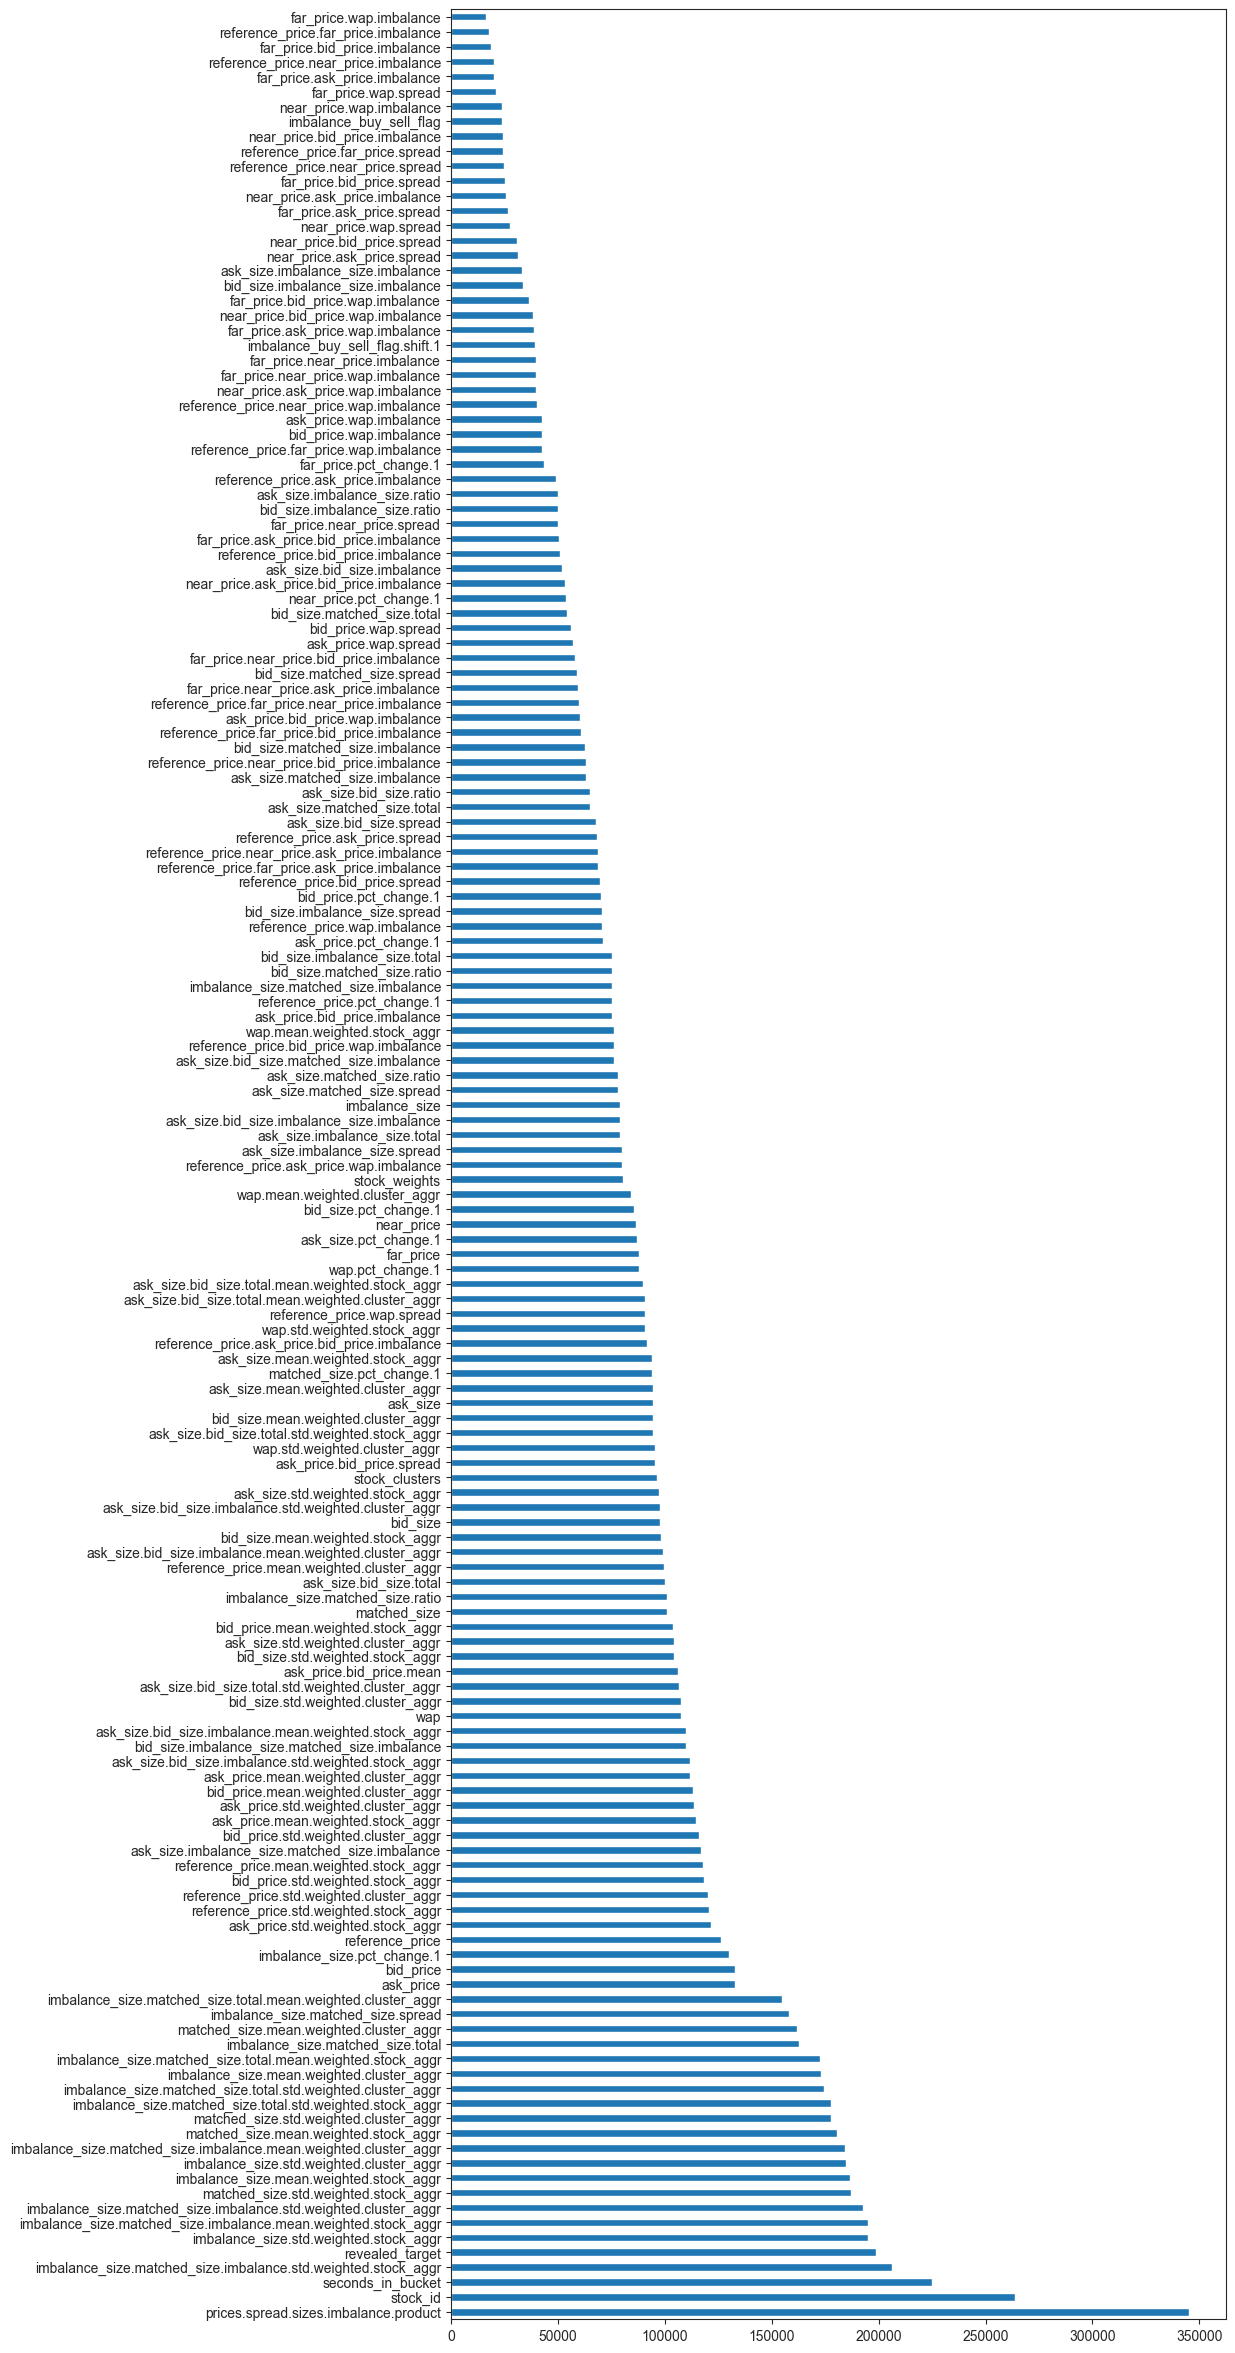

In [20]:
agreggated_feature_importances = (sum([model.booster_.feature_importance(importance_type="gain") \
                                       for model in trained_models])/len(trained_models)).astype(np.int32)

agreggated_feature_importances = pd.Series(agreggated_feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 30))
agreggated_feature_importances.plot(kind='barh')

In [21]:
from utils.files import dump_json

if CFG.FEAT_COUNT > 0:
    selected_features = list(agreggated_feature_importances.index[:CFG.FEAT_COUNT]) # Select the desired results
else:
    selected_features = list(df.columns) # Select all

# Add essential features if not in the selected features
selected_features.extend(["target", "stock_id", "seconds_in_bucket"])
selected_features = list(dict.fromkeys(selected_features))

logger.info("Selected features are: ")
pprint(selected_features)

metadata = {
    "selected_features": selected_features,
    "stock_weights": stock_weights,
    "stock_clusters": stock_clusters
}
dump_json(CFG.JOB_PATH.joinpath(CFG.OUTPUT_METADATA_NAME), metadata, indent=4)

2023-11-08 23:01:34.820 | INFO     | __main__:<module>:12 - Selected features are: 


['stock_id',
 'seconds_in_bucket',
 'imbalance_size',
 'imbalance_buy_sell_flag',
 'reference_price',
 'matched_size',
 'far_price',
 'near_price',
 'bid_price',
 'bid_size',
 'ask_price',
 'ask_size',
 'wap',
 'target',
 'ask_size.bid_size.spread',
 'ask_size.bid_size.total',
 'ask_size.bid_size.ratio',
 'ask_size.bid_size.imbalance',
 'ask_size.imbalance_size.spread',
 'ask_size.imbalance_size.total',
 'ask_size.imbalance_size.ratio',
 'ask_size.imbalance_size.imbalance',
 'ask_size.matched_size.spread',
 'ask_size.matched_size.total',
 'ask_size.matched_size.ratio',
 'ask_size.matched_size.imbalance',
 'bid_size.imbalance_size.spread',
 'bid_size.imbalance_size.total',
 'bid_size.imbalance_size.ratio',
 'bid_size.imbalance_size.imbalance',
 'bid_size.matched_size.spread',
 'bid_size.matched_size.total',
 'bid_size.matched_size.ratio',
 'bid_size.matched_size.imbalance',
 'imbalance_size.matched_size.spread',
 'imbalance_size.matched_size.total',
 'imbalance_size.matched_size.ratio',